In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


import seaborn as sns

In [2]:
annotation = sc.read_h5ad("./RNA/Multitime.annotation.fixed.h5")
fdata = sc.read_h5ad("./RNA/Multitime.clustered.h5")

In [3]:
annotation.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(annotation.obs["marker"], annotation.obsm["spatial"])]
fdata.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(fdata.obs["marker"], fdata.obsm["spatial"])]

map_df = fdata.obs[["cluster_cellcharter_givenk", "cov"]]
map_df.index = fdata.obs["cov"]
map_df = map_df.iloc[:, :-1].unstack()
map_dict = map_df["cluster_cellcharter_givenk"].to_dict()
annotation.obs["cluster"] = annotation.obs["cov"].map(map_dict)

annotation = annotation[~annotation.obs["cluster"].isna()]

In [21]:
expr_matrix = np.zeros((len(annotation.var_names), len(np.unique(annotation.obs.cluster)) * len(np.unique(annotation.obs.annotations))))

for i, sample in enumerate(np.unique(annotation.obs.cluster)):
    for j, celltype in enumerate(np.unique(annotation.obs.annotations)):
        if celltype.endswith('T'):
            mask = (annotation.obs.cluster == sample) & (annotation.obs.annotations == celltype)
            expr_matrix[:, i * len(np.unique(annotation.obs.annotations)) + j] = annotation[mask].X.toarray().sum(axis=0)


In [23]:
df = pd.DataFrame(expr_matrix.T)
df['annotations'] = np.repeat(np.unique(annotation.obs.annotations), len(np.unique(annotation.obs.cluster)))
df['cluster'] = np.repeat(np.unique(annotation.obs.cluster), len(np.unique(annotation.obs.annotations)))
df.columns = annotation.var_names.tolist() + ['annotations', 'cluster']
df

0610005C13Rik  0610009B22Rik  0610009O20Rik  0610010F05Rik  \
0              0.0            0.0            0.0            0.0   
1              0.0            0.0            0.0            0.0   
2              0.0            0.0            0.0            0.0   
3              0.0            0.0            0.0            0.0   
4              0.0            0.0            0.0            0.0   
..             ...            ...            ...            ...   
163            4.0          108.0          119.0           89.0   
164            0.0           58.0          106.0           46.0   
165            0.0            4.0           12.0            5.0   
166            0.0           25.0            6.0            7.0   
167            0.0            3.0            5.0            2.0   

     0610010K14Rik  0610012D04Rik  0610012G03Rik  0610030E20Rik  \
0              0.0            0.0            0.0            0.0   
1              0.0            0.0            0.0            0.0   
2              0.0            0.0            0.0            0.0   
3              0.0            0.0            0.0            0.0   
4              0.0            0.0            0.0            0.0   
..             ...            ...            ...            ...   
163          188.0            1.0          318.0           73.0   
164          152.0            2.0          269.0           55.0   
165           19.0            0.0           32.0            9.0   
166           18.0            0.0           39.0           11.0   
167           13.0            0.0           19.0            3.0   

     0610037L13Rik  0610038B21Rik  ...  mt-Co3  mt-Cytb   mt-Nd1  mt-Nd2  \
0              0.0            0.0  ...     0.0      0.0      0.0     0.0   
1              0.0            0.0  ...     0.0      0.0      0.0     0.0   
2              0.0            0.0  ...     0.0      0.0      0.0     0.0   
3              0.0            0.0  ...     0.0      0.0      0.0     0.0   
4              0.0            0.0  ...     0.0      0.0      0.0     0.0   
..             ...            ...  ...     ...      ...      ...     ...   
163          106.0            4.0  ...     4.0  18674.0  10665.0  2766.0   
164           67.0            1.0  ...     3.0  13586.0   8585.0  2166.0   
165           15.0            0.0  ...     1.0   2033.0   1213.0   337.0   
166           15.0            2.0  ...     0.0   1682.0    934.0   276.0   
167            7.0            0.0  ...     0.0   1337.0    840.0   243.0   

     mt-Nd3   mt-Nd4  mt-Nd5  mt-Nd6  annotations  cluster  
0       0.0      0.0     0.0     0.0           DC      0.0  
1       0.0      0.0     0.0     0.0           DC      0.0  
2       0.0      0.0     0.0     0.0           DC      0.0  
3       0.0      0.0     0.0     0.0           DC      0.0  
4       0.0      0.0     0.0     0.0           DC      0.0  
..      ...      ...     ...     ...          ...      ...  
163    11.0  12589.0   508.0    48.0  stem-like T     11.0  
164     8.0   9991.0   392.0    59.0  stem-like T     11.0  
165     1.0   1539.0    48.0     9.0  stem-like T     11.0  
166     1.0   1132.0    41.0    14.0  stem-like T     11.0  
167     0.0    878.0    30.0     7.0  stem-like T     11.0  

[168 rows x 19602 columns]

In [24]:
df.to_csv("./plots/cluster_lr.csv", index=False)

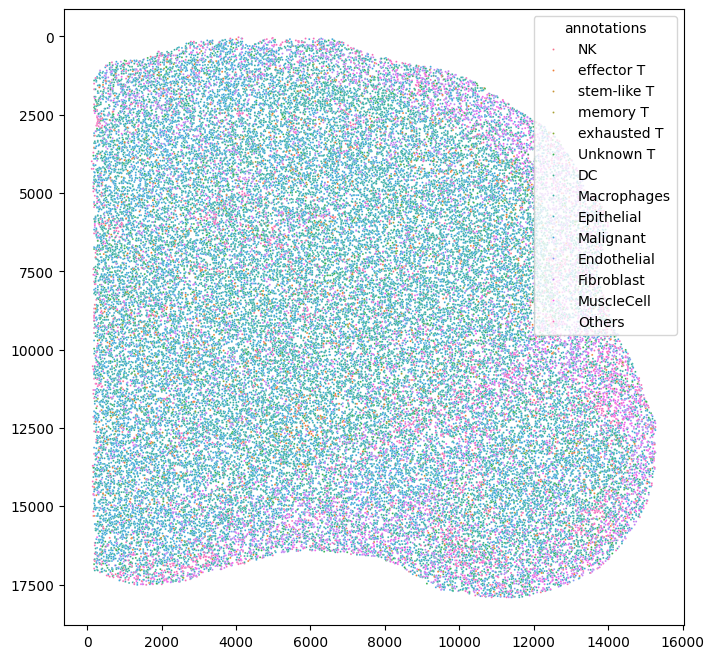

In [17]:
# 进行plotdata的subsampling
plot_data = fdata[(fdata.obs.marker == "2-1") &
                  (fdata.obsm['spatial'][:, 0] > 0) &
                  (fdata.obsm['spatial'][:, 0] < 20000) &
                  (fdata.obsm['spatial'][:, 1] > 0) &
                  (fdata.obsm['spatial'][:, 1] < 20000)]

# 随机选择plot_data中的10%进行绘图
sample_size = int(len(plot_data) * 0.1)
plot_data = plot_data[np.random.choice(plot_data.obs_names, sample_size, replace=False)]

plt.figure(figsize=(8, 8))
sns.scatterplot(x=plot_data.obsm["spatial"][:, 0], y=plot_data.obsm["spatial"][:, 1], hue=plot_data.obs["annotations"], s=2)
plt.gca().invert_yaxis()
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_56971/1339080368.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # 去除图片边缘的留白


<Figure size 4800x4800 with 0 Axes>

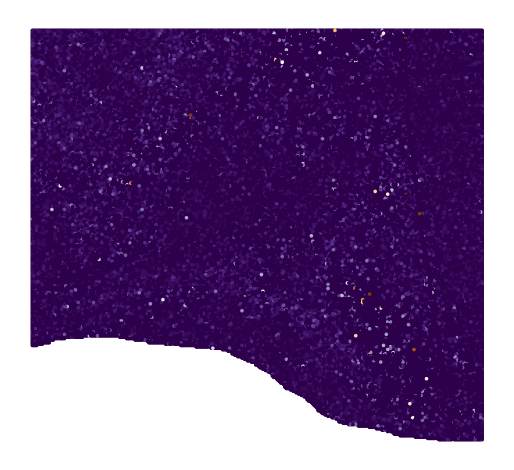

In [18]:
plt.figure(figsize=(8, 8), dpi=600)
plot_data = fdata[(fdata.obs.marker == "2-1") &
                  (fdata.obsm["spatial"][:, 0] < 11500) &
                  (fdata.obsm["spatial"][:, 0] > 5000) &
                  (fdata.obsm["spatial"][:, 1] < 18000) &
                  (fdata.obsm["spatial"][:, 1] > 12000)]
sc.pp.normalize_total(plot_data, inplace=True, target_sum=1e4)
# plot_data = fdata[fdata.obs.marker == "2-1"]
sq.pl.spatial_scatter(plot_data, color='Ctsb', shape=None, size=10, vmax=1000, library_id='spatial', colorbar=False, cmap='PuOr_r')
plt.xlabel('')
plt.ylabel('')
plt.title('')
sns.despine(left=True, bottom=True)
plt.tight_layout()  # 去除图片边缘的留白
plt.show()


/tmp/ipykernel_21490/2763997852.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(df_final, y=df_final.index, x="count", palette="Blues", alpha=0.8, orient="h")


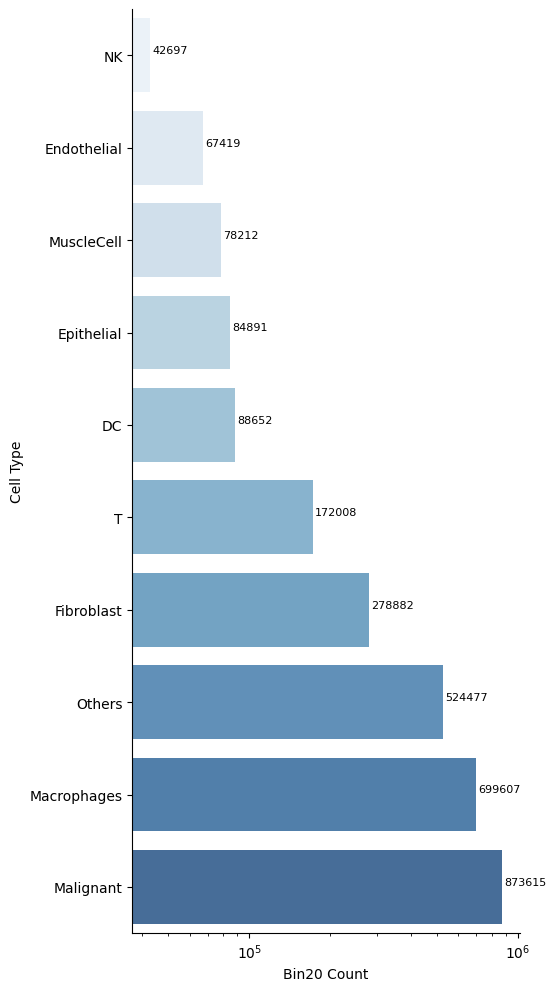

In [45]:
df = fdata.obs["annotations"].value_counts()
df = df.sort_index()  # 按索引排序
df_t = df[df.index.str.endswith('T')]  # 选择末尾是T的项
df_t = pd.DataFrame({
    'count': df_t.sum()
}, index=["T"])
df_other = df[~df.index.str.endswith('T')]  # 选择其他项
df_final = pd.concat([df_t, df_other])  # 合并结果
df_final.sort_values(by="count", ascending=True, inplace=True)
plt.figure(figsize=(5, 12))
ax = sns.barplot(df_final, y=df_final.index, x="count", palette="Blues", alpha=0.8, orient="h")
for i, v in enumerate(df_final["count"]):
    ax.text(v*1.02, i, str(v), ha="left", va="bottom", fontsize=8)
plt.xscale("log")
plt.ylabel("Cell Type")
plt.xlabel("Bin20 Count")
sns.despine(left=False, bottom=False)
plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/time_point_celltype_count.pdf", format="pdf", bbox_inches='tight')
plt.show()


In [38]:
import random

# 随机选择fdata中5%的bin
num_bins = fdata.n_obs
sample_size = int(num_bins * 0.05)
random_indices = random.sample(range(num_bins), sample_size)
random_bins = fdata[random_indices]

sc.pp.normalize_total(random_bins, inplace=True, target_sum=1e4)
sc.pp.log1p(random_bins)

random_bins.obs.annotations = random_bins.obs.annotations.map(lambda x: x.split(' ')[1] if x.endswith('T') else x)
random_bins.obs.annotations = random_bins.obs.annotations.map(lambda x: 'Malignant' if x == 'Epithelial' else x)
random_bins = random_bins[random_bins.obs.annotations != 'Others']
sc.tl.rank_genes_groups(random_bins, groupby='annotations', method='t-test')


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for

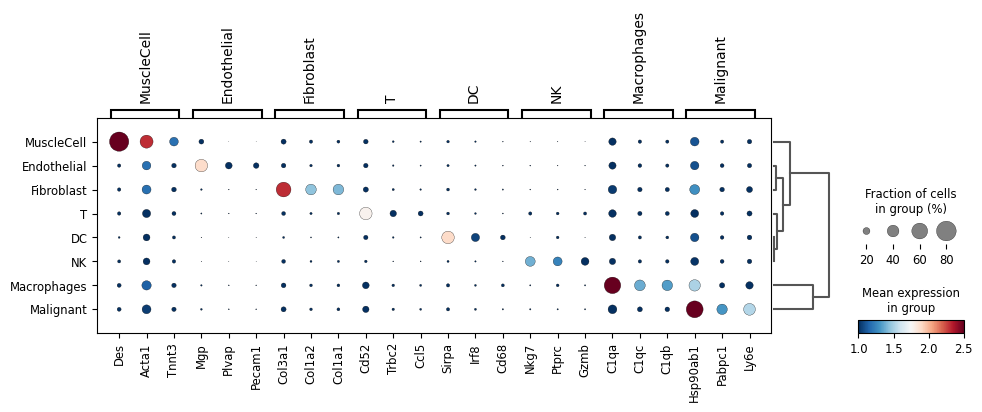

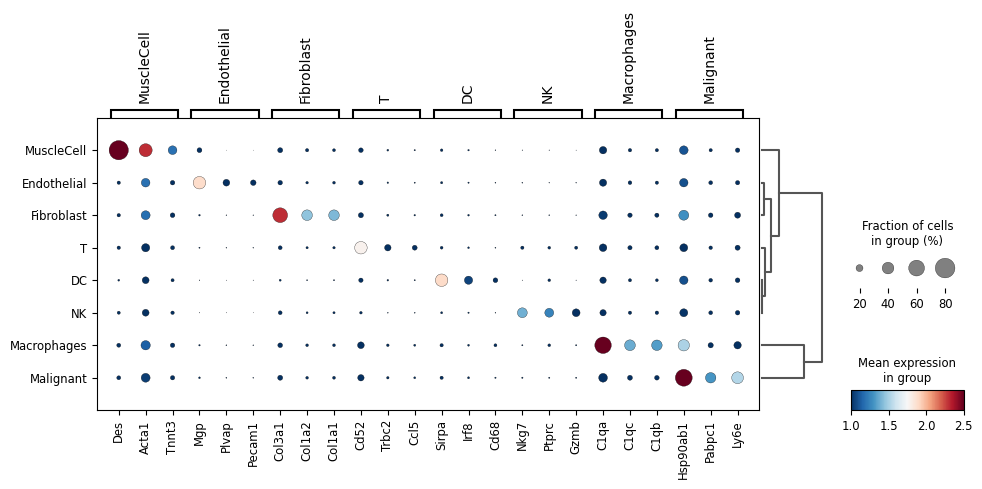

In [41]:
fig = sc.pl.rank_genes_groups_dotplot(random_bins, n_genes=3, return_fig=True, show=False, cmap='RdBu_r', vmax=2.5, vmin=1)
fig.get_axes()['mainplot_ax'].set_ylabel('')

plt.rcParams['pdf.fonttype']=42
fig.savefig("./plots/celltype_marker_dotplot.pdf", format="pdf", bbox_inches='tight')
# fig.show()

In [19]:
def extract_bin20(bin20_data, bin100_masked_data, replace_obs=None):

    try:
        bin100_mask = bin100_masked_data.obs["spatial_cov"].tolist()
        mask = [array in bin100_mask for array in bin20_data.obs["spatial_cov"]]
    except:
        bin20_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_data.obsm["spatial"]]
        bin100_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_masked_data.obsm["spatial"]]
        mask = [array in bin100_masked_data.obs["spatial_cov"].tolist() for array in tqdm(bin20_data.obs["spatial_cov"])]

    if replace_obs:
        for obj in replace_obs:
            spatial_to_obs = dict(zip(bin100_masked_data.obs["spatial_cov"], bin100_masked_data.obs[obj]))
            bin20_data.obs[obj] = bin20_data.obs["spatial_cov"].map(spatial_to_obs)
    return bin20_data[mask].copy()

def extract_bin100(bin100_data, bin20_masked_data):

    try:
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    except:
        bin100_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_data.obsm["spatial"]]
        bin20_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_masked_data.obsm["spatial"]]
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    return bin100_data[mask].copy()

def find_near(bin100, bin100_data, border=1, bin_size=100):
    #print("center of bin is ", bin100.obsm["spatial"][0])
    cmin = ((bin100.obsm["spatial"] // bin_size - border) * bin_size)[0]
    cmax = ((bin100.obsm["spatial"] // bin_size + border + 1) * bin_size)[0]
    #print("extracting bin from ", cmin, "to", cmax)
    mask = [cmin[0] <= array[0] <= cmax[0] and cmin[1] <= array[1] <= cmax[1] for array in bin100_data.obsm["spatial"]]
    return bin100_data[mask]

In [5]:
fdata_bin100 = sc.read_h5ad("./RNA/Multitime.clustered.h5")
fdata_bin100

AnnData object with n_obs × n_vars = 118279 × 13177
    obs: 'marker', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter_givenk'
    var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
    uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_givenk_colors', 'log1p', 'rank_genes_groups', 'spatial_neighbors'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [6]:
plot_data = fdata_bin100[fdata_bin100.obs.marker == "3-1"]
sq.gr.nhood_enrichment(plot_data, connectivity_key='spatial', cluster_key='cluster_cellcharter_givenk')


  0%|          | 0/1000 [00:00<?, ?/s]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/gr/_utils.py:193: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  obj[key] = data


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


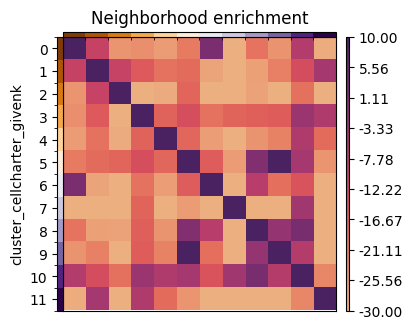

In [7]:
sq.pl.nhood_enrichment(plot_data, cluster_key='cluster_cellcharter_givenk', cmap='flare', vmax=10, vmin=-30, palette='PuOr', figsize=(3, 3))
plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/cluster_proximity_3-1.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [16]:
mask = (annotation.obs["marker"] == "2-1") &\
    (annotation.obsm['spatial'][:, 0] < 50000) & (annotation.obsm['spatial'][:, 0] > 00000) &\
    (annotation.obsm['spatial'][:, 1] < 50000) & (annotation.obsm['spatial'][:, 1] > 00000)
plot_data = annotation[mask].copy()
plot_data.obs.annotations = plot_data.obs.annotations.map(lambda x: x.split(' ')[1] if x.endswith('T') else x)
plot_data = plot_data[plot_data.obs.annotations != 'Others', :].copy()
# sq.pl.spatial_scatter(plot_data, color='annotations', shape=None, size=10, library_id='spatial')

In [17]:
sq.gr.spatial_neighbors(plot_data, coord_type="generic", delaunay=False, library_key='marker', radius=35, set_diag=True, key_added='inter')

In [19]:
plot_data.obs.annotations = plot_data.obs.annotations.astype('category')
sq.gr.nhood_enrichment(plot_data, connectivity_key='inter', cluster_key='annotations')

  0%|          | 0/1000 [00:00<?, ?/s]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


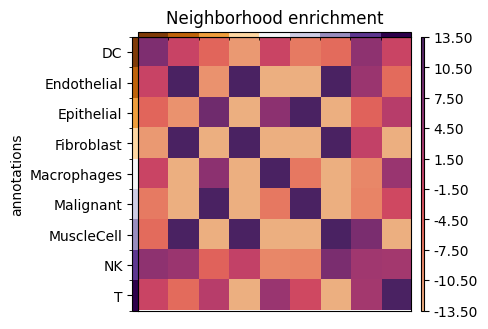

In [20]:
sq.pl.nhood_enrichment(plot_data, cluster_key='annotations', cmap='flare', vmax=13.5, vmin=-13.5, palette='PuOr', figsize=(3, 3))

In [37]:
df = pd.DataFrame(plot_data.uns['annotations_nhood_enrichment']['zscore'],
             index=plot_data.obs.annotations.unique(),
             columns=plot_data.obs.annotations.unique()).melt(ignore_index=False).reset_index()
df.columns = ['source', 'target', 'weight']
df.weight = df.weight.map(lambda x: x if x < df.weight.quantile(0.9) else df.weight.quantile(0.9))
df.to_csv("./celltype_proximity.csv", index=False)

In [86]:
(plot_guide_data.X.sum(axis=1) > 0)

matrix([], shape=(0, 1), dtype=bool)

In [87]:
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.bin20.h5')
gdata.obs.marker = gdata.obs.marker.map({
    'B924-2': '1-2',
    'B924-1': '1-1',
    'B926-2': '2-2',
    'B926-1': '2-1',
    'B922-2': '3-2',
    'B922-1': '3-1'
})

In [108]:
# search for window with highest correlation
from scipy.spatial import distance_matrix
from tqdm import tqdm

xy_dict = {}
# sc.tl.score_genes(fdata, ['Cd8a', 'Cd8b1', 'Cd52', 'Cd3e', 'Cd3d', 'Cd3g'], score_name='T_score')
for sample in np.unique(fdata.obs["marker"]):
    plot_data = fdata[fdata.obs["marker"] == sample].copy()
    plot_guide_data = gdata[gdata.obs["marker"] == sample].copy()
    plot_data.obs.annotations = plot_data.obs.annotations.map(lambda x: x.split(' ')[1] if x.endswith('T') else x)
    max_x = plot_data.obsm["spatial"][:, 0].max()
    max_y = plot_data.obsm["spatial"][:, 1].max()
    xy_dict[sample] = []
    for i in tqdm(range(max_x // 2000)):
        for j in range(max_y // 2000):
            mask = (plot_data.obsm["spatial"][:, 0] >= i * 2000) & (plot_data.obsm["spatial"][:, 0] < (i + 1) * 2000) & \
                (plot_data.obsm["spatial"][:, 1] >= j * 2000) & (plot_data.obsm["spatial"][:, 1] < (j + 1) * 2000)
            high_t_bin = plot_data[(plot_data.obs.T_score > plot_data.obs.T_score.quantile(0.8)) & mask].obsm['spatial']
            t_bin = plot_guide_data[np.array((plot_guide_data.X.sum(axis=1) > 0)).flatten() & mask].obsm['spatial']
            if high_t_bin.shape[0] > 0 and t_bin.shape[0] > 0:
                dist_matrix = distance_matrix(high_t_bin, t_bin)
                xy_dict[sample].append((i, j, dist_matrix.min(axis=1).mean()))

100%|██████████| 8/8 [00:01<00:00,  6.42it/s]


In [110]:
d_array[:, 2]

array([17.49239326, 11.25477546,  9.80273068, 11.50555167, 12.43092281,
       11.72216216, 10.23328356, 11.14622786, 12.1559738 , 13.45034764,
       13.40296509, 11.47974221, 13.51250017, 19.55665644, 13.35088251,
       14.54507939, 15.10624633, 16.10613174, 12.95357453, 14.72664604,
       19.97088965, 13.82688139, 16.49172665, 18.15328761, 14.82344148,
       14.592959  , 21.61943596, 29.67330379, 17.60034339, 15.98129202,
       17.38517475, 28.39058943, 19.71788985, 17.32521283, 13.91832177,
       23.53645882])

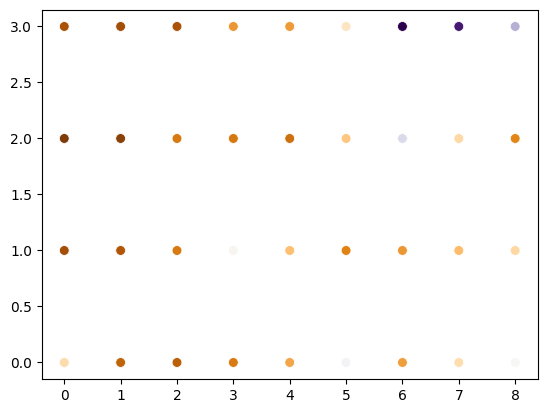

In [124]:
d_array = np.array(xy_dict["2-2"]).reshape(-1, 3)
sns.scatterplot(x=d_array[:, 0], y=d_array[:, 1], c=d_array[:, 2], cmap='PuOr', s=50)
plt.show()



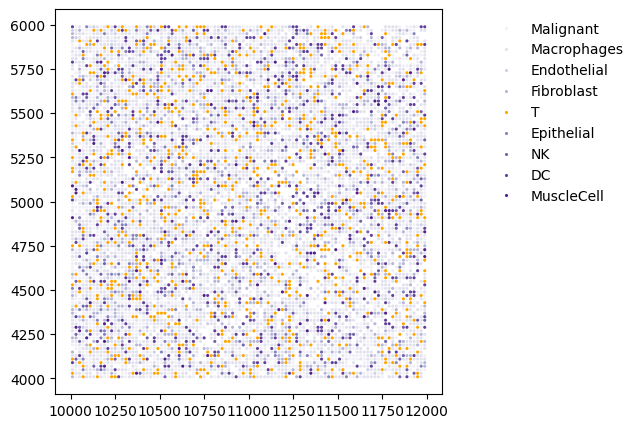

In [125]:
mask = (fdata.obs["marker"] == "2-2") &\
    (fdata.obsm['spatial'][:, 0] < 12000) & (fdata.obsm['spatial'][:, 0] > 10000) &\
    (fdata.obsm['spatial'][:, 1] < 6000) & (fdata.obsm['spatial'][:, 1] > 4000)
plot_data = fdata[mask].copy()
plot_data.obs.annotations = plot_data.obs.annotations.map(lambda x: x.split(' ')[1] if x.endswith('T') else x)
plot_data = plot_data[plot_data.obs.annotations != 'Others', :].copy()

# 取9个颜色，只有T的颜色是1，其余的偏紫色，即0-0.1
colors = sns.color_palette("Purples", 9)
palette = {celltype: colors[i] for i, celltype in enumerate(plot_data.obs.annotations.unique())}
palette['T'] = 'orange'

plt.figure(figsize=(5, 5))
sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1], hue=plot_data.obs.annotations, palette=palette, s=5, edgecolor='none', legend='full')
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.5, 1))

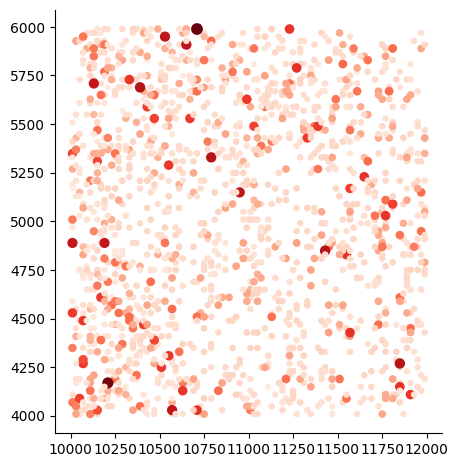

In [126]:
plt.figure(figsize=(5, 5.5))
sc.tl.score_genes(plot_data, ['Cd8a', 'Cd8b1', 'Cd52', 'Cd3e', 'Cd3d', 'Cd3g'], score_name='T_score')
plot_data = plot_data[plot_data.obs.T_score > 0]
# plot_data.obs.T_score = plot_data.obs.T_score.map(lambda x: x if x > 0 else 0)
# plt.gca().set_facecolor('black')
# sns.kdeplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1], weights=plot_data.obs.T_score.tolist(), cmap='PuOr', bw_adjust=0.3, alpha=0.6, fill=True, cbar=True, cbar_kws={'label': 'T Score', 'orientation': 'horizontal', 'pad': 0.05, 'ticks': np.linspace(1e-8, 1e-6, 10)})
sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1], c=plot_data.obs.T_score, size=plot_data.obs.T_score, cmap='Reds', vmax=1, vmin=0, s=5, edgecolor='none', legend=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

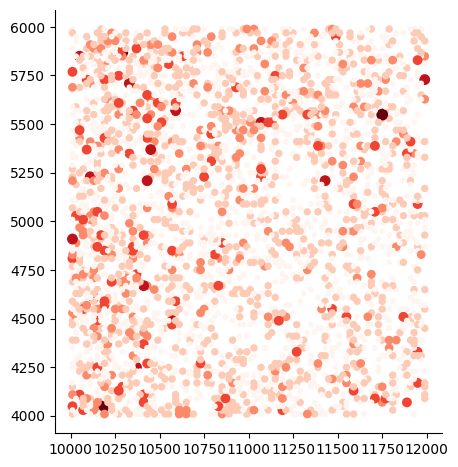

In [128]:
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.bin20.h5')
mask = (gdata.obs["marker"] == "B926-2") &\
    (gdata.obsm['spatial'][:, 0] < 12000) & (gdata.obsm['spatial'][:, 0] > 10000) &\
    (gdata.obsm['spatial'][:, 1] < 6000) & (gdata.obsm['spatial'][:, 1] > 4000)
plot_data = fdata[mask].copy()
plot_guide_data = gdata[mask].copy()
plot_guide_data = plot_guide_data[plot_guide_data.X.sum(axis=1) > 0]
plt.figure(figsize=(5, 5.5))
# plt.gca().set_facecolor('black')
sns.scatterplot(x=plot_guide_data.obsm['spatial'][:, 0], y=plot_guide_data.obsm['spatial'][:, 1], c=np.array(plot_guide_data.X.sum(axis=1)).flatten(), cmap='Reds', size=np.array(plot_guide_data.X.sum(axis=1)).flatten()/20, edgecolor='none', legend=False)
# sns.kdeplot(x=plot_guide_data.obsm['spatial'][:, 0], y=plot_guide_data.obsm['spatial'][:, 1], weights=np.array(plot_guide_data.X.sum(axis=1)).flatten(), cmap='PuOr', bw_adjust=0.3, alpha=0.6, fill=True, cbar=True,
            # cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'ticks': np.linspace(1e-8, 1e-6, 6)})
sns.despine()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


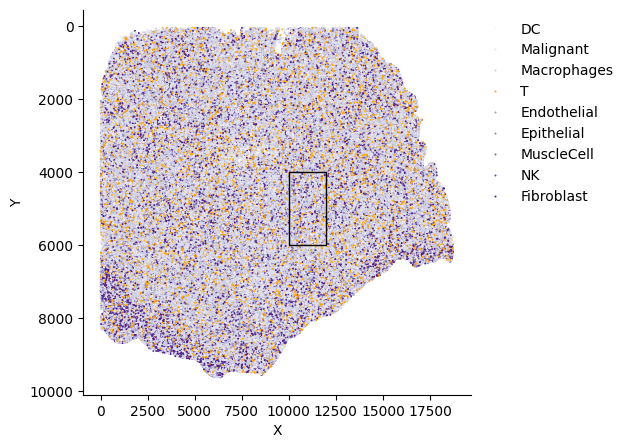

In [129]:
plt.figure(figsize=(5, 5))
plot_data = fdata[fdata.obs.marker == "2-2"]
plot_data.obs.annotations = plot_data.obs.annotations.map(lambda x: x.split(' ')[1] if x.endswith('T') else x)
plot_data = plot_data[plot_data.obs.annotations != 'Others', :].copy()
# 取9个颜色，只有T的颜色是1，其余的偏紫色，即0-0.1
colors = sns.color_palette("Purples", 9)
palette = {celltype: colors[i] for i, celltype in enumerate(plot_data.obs.annotations.unique())}
palette['T'] = 'orange'
sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1], hue=plot_data.obs.annotations, palette=palette, s=2, edgecolor='none', legend=True)
plt.gca().add_patch(plt.Rectangle((10000, 4000), 2000, 2000, fill=False, edgecolor='black', linewidth=1))
plt.gca().invert_yaxis()
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.4, 1))
plt.xlabel('X')
plt.ylabel('Y')
sns.despine()
plt.show()

# Calculate the bin100 coordinate for bin20

In [8]:
fdata.obs['x_bin100'] = fdata.obsm["spatial"][:, 0] // 100 * 100
fdata.obs['y_bin100'] = fdata.obsm["spatial"][:, 1] // 100 * 100

fdata_bin100.obs["x_bin100"] = fdata_bin100.obsm["spatial"][:, 0] // 100 * 100
fdata_bin100.obs["y_bin100"] = fdata_bin100.obsm["spatial"][:, 1] // 100 * 100

In [9]:
bin100_df = fdata_bin100.obs[["x_bin100", "y_bin100", "cluster_cellcharter_givenk", 'marker']].set_index(["marker", "x_bin100", "y_bin100"])
bin20_df = fdata.obs[["x_bin100", "y_bin100", "annotations", "marker"]].set_index(["marker", "x_bin100", "y_bin100"])

# 直接合并，不使用agg
df = pd.merge(bin100_df, bin20_df, left_index=True, right_index=True, how='inner')
df

cluster_cellcharter_givenk  annotations
marker x_bin100 y_bin100                                        
1-1    6700     400                               9  Macrophages
                400                               9   Fibroblast
                400                               9  Macrophages
                400                               9   MuscleCell
                400                               9   Epithelial
...                                             ...          ...
3-2    7800     12900                            10       Others
       13700    12900                             5    Malignant
                12900                             5       Others
       2900     12900                             5       Others
                12900                             5       Others

[2910238 rows x 2 columns]

In [10]:
cdfs = []
for sample in np.unique(df.index.get_level_values(0)):
    cdf = df[df.index.get_level_values(0) == sample]
    cdf.annotations = cdf.annotations.apply(lambda x: x.split(' ')[1] if x.endswith('T') else x)
    c_df = cdf.groupby("cluster_cellcharter_givenk")["annotations"].value_counts()
    c_df = c_df.unstack().filter(regex='^[^O]')
    c_df = c_df.melt(ignore_index=False)
    c_df.columns = ["celltype", "count"]
    c_df["marker"] = sample
    cdfs.append(c_df)
cdfs = pd.concat(cdfs)
cdfs.reset_index(inplace=True)
cdfs


/tmp/ipykernel_14649/400893627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf.annotations = cdf.annotations.apply(lambda x: x.split(' ')[1] if x.endswith('T') else x)
/tmp/ipykernel_14649/400893627.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = cdf.groupby("cluster_cellcharter_givenk")["annotations"].value_counts()
/tmp/ipykernel_14649/400893627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

cluster_cellcharter_givenk celltype  count marker
0                            0       DC    501    1-1
1                            1       DC   2331    1-1
2                            2       DC    439    1-1
3                            3       DC    595    1-1
4                            4       DC    473    1-1
..                         ...      ...    ...    ...
643                          7        T    393    3-2
644                          8        T   1081    3-2
645                          9        T     80    3-2
646                         10        T    452    3-2
647                         11        T   3580    3-2

[648 rows x 4 columns]

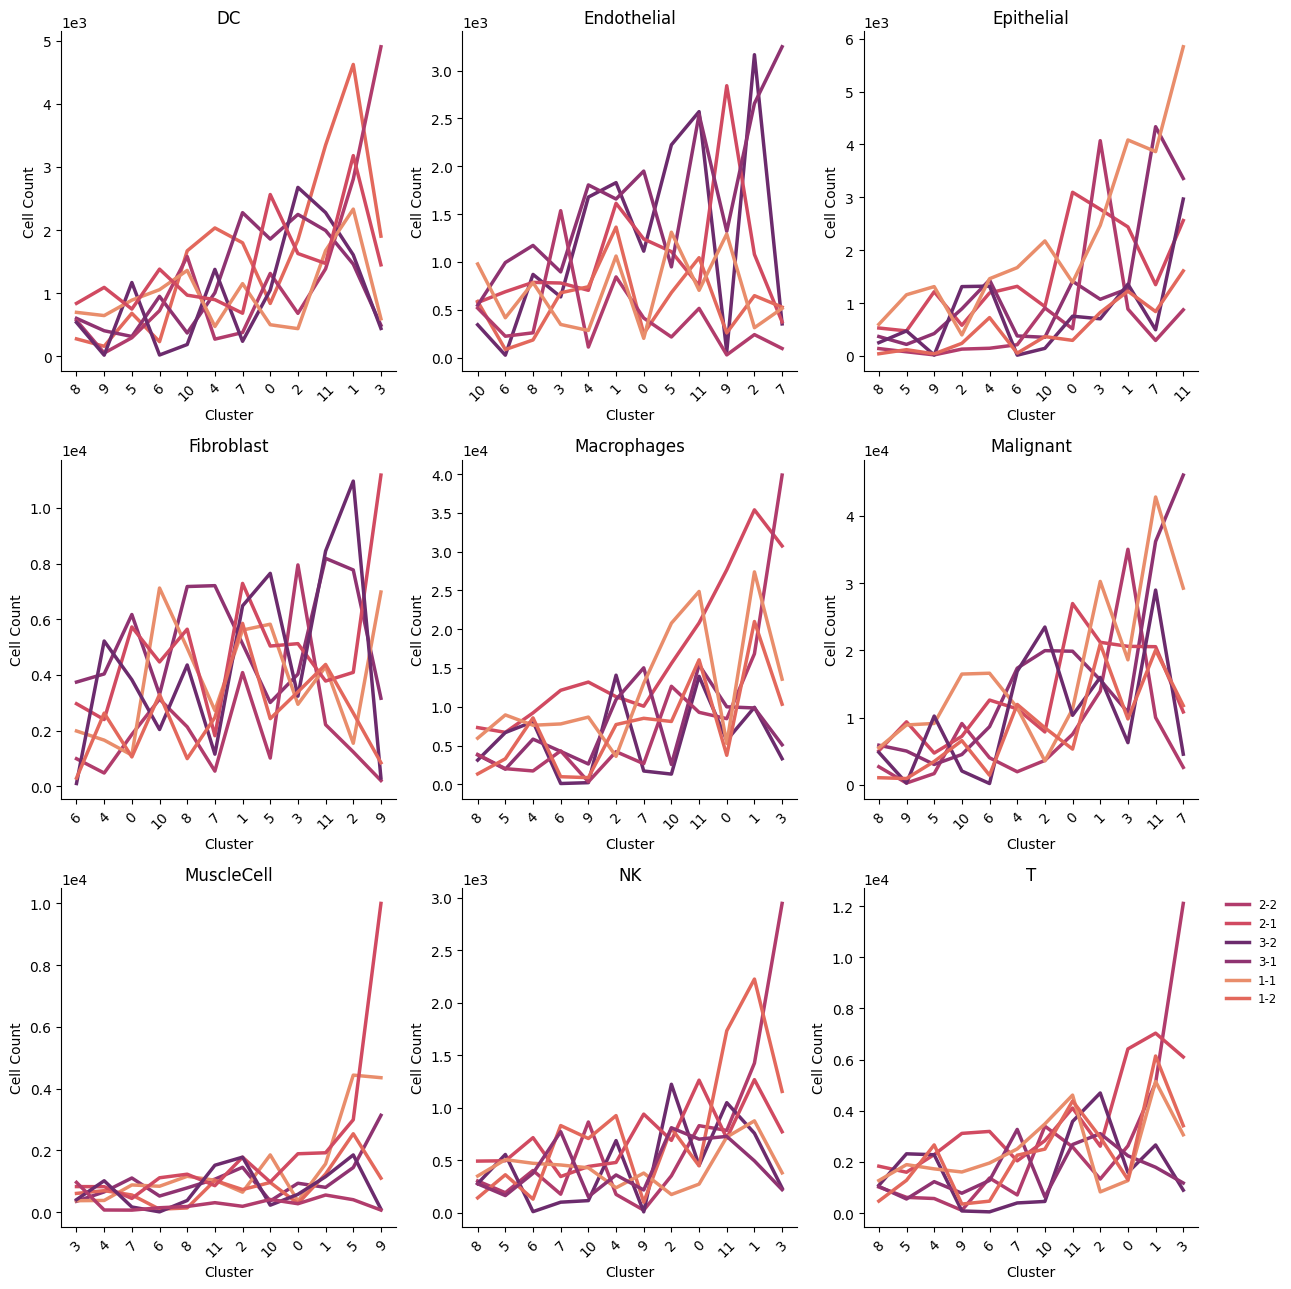

In [95]:
df_guides = cdfs.copy()
df_guides.cluster_cellcharter_givenk = df_guides.cluster_cellcharter_givenk.astype(str)
# df_guides = df_guides.loc[~np.isin(df_guides['sample'], ['3-2', '3-1']), :]
guides_of_interest = df_guides.celltype.unique()

# 计算每个guide的cluster顺序
order_dict = {}
celltypes_of_interest = df_guides.celltype.unique()
for celltype in celltypes_of_interest:
    celltype_data = df_guides[df_guides.celltype == celltype]
    mean_by_cluster = celltype_data.groupby('cluster_cellcharter_givenk')['count'].max()
    order_dict[celltype] = mean_by_cluster.sort_values().index.tolist()

# 创建颜色映射
guide_color_map = sns.color_palette("Set3", len(guides_of_interest))
sample_color_map = sns.color_palette("flare", len(df_guides['marker'].unique()))
guide_color_map_dict = {celltype: guide_color_map[i] for i, celltype in enumerate(celltypes_of_interest)}
sample_color_map_dict = {sample: sample_color_map[i] for i, sample in enumerate(df_guides['marker'].unique())}

# 创建子图
fig, axes = plt.subplots(3, 3, figsize=(13, 13))
axes = axes.flatten()

# 设置统一的y轴范围
y_min = df_guides['count'].min()
y_max = df_guides['count'].max()

# 为每个guide绘制子图
for ax, celltype in zip(axes, celltypes_of_interest):
    # 获取该guide的数据并按order_dict排序
    celltype_data = df_guides[df_guides.celltype == celltype].copy()
    celltype_data['cluster_cellcharter_givenk'] = pd.Categorical(celltype_data['cluster_cellcharter_givenk'], 
                                         categories=order_dict[celltype],
                                         ordered=True)
    celltype_data = celltype_data.sort_values('cluster_cellcharter_givenk')
    
    # 绘制线图
    sns.lineplot(data=celltype_data, x='cluster_cellcharter_givenk', y='count', 
                hue='marker',
                ax=ax, palette=sample_color_map_dict, linewidth=2.5, linestyle='-')
    
    # 设置标题和标签
    if ax != axes[8]: ax.legend([], frameon=False)
    else: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', fontsize='small', frameon=False)
    ax.set_title(celltype)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Cell Count')
    ax.set_xticks(list(range(len(order_dict[celltype]))))
    ax.tick_params(axis='x', rotation=45)
    
    # 设置统一的y轴范围
    # ax.set_ylim(y_min, y_max)
    # 设置y轴刻度为科学计数法格式
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # 移除右边和顶部的边框
    sns.despine(ax=ax)
plt.tight_layout()
plt.show()


In [24]:
celltype_data

NameError: name 'celltype_data' is not defined

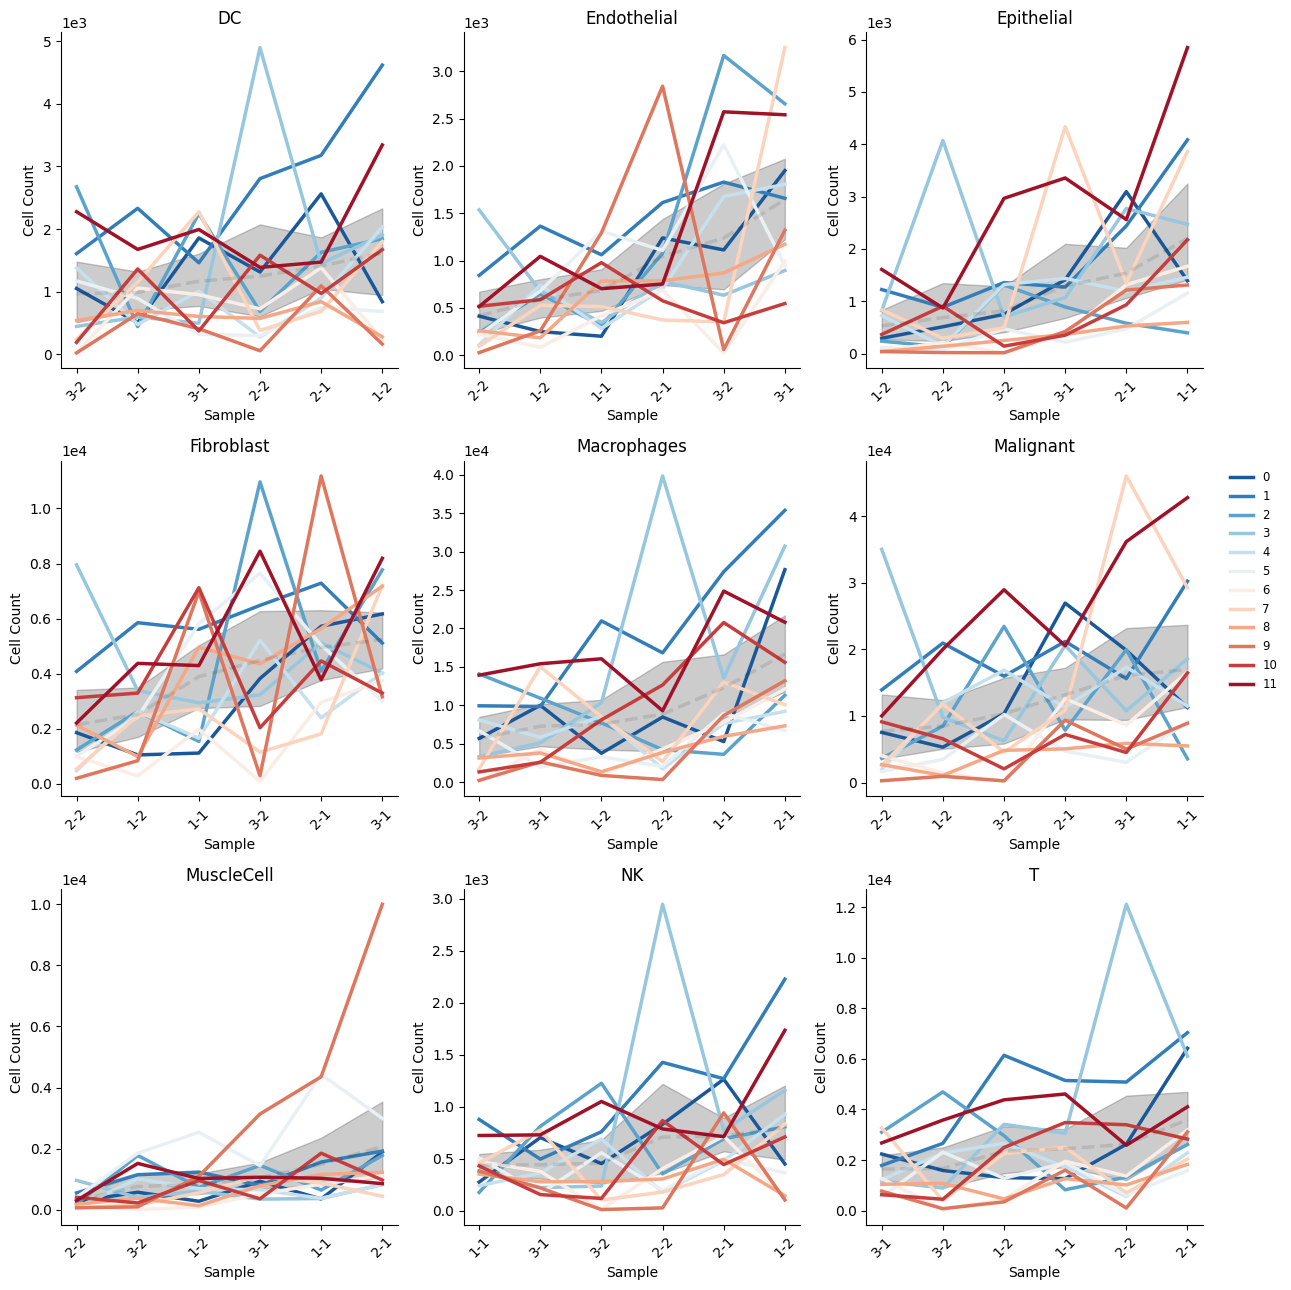

In [117]:
df_guides = cdfs.copy()
df_guides.marker = df_guides.marker.astype(str)
# df_guides = df_guides.loc[~np.isin(df_guides['marker'], ['3-2', '3-1']), :]
guides_of_interest = df_guides.celltype.unique()

# 计算每个guide的marker顺序
order_dict = {}
celltypes_of_interest = df_guides.celltype.unique()
for celltype in celltypes_of_interest:
    celltype_data = df_guides[df_guides.celltype == celltype]
    mean_by_marker = celltype_data.groupby('marker')['count'].sum()
    order_dict[celltype] = mean_by_marker.sort_values().index.tolist()

# 创建颜色映射
guide_color_map = sns.color_palette("Set3", len(guides_of_interest))
marker_color_map = sns.color_palette("RdBu_r", len(df_guides['cluster_cellcharter_givenk'].unique()))
guide_color_map_dict = {celltype: guide_color_map[i] for i, celltype in enumerate(celltypes_of_interest)}
marker_color_map_dict = {marker: marker_color_map[i] for i, marker in enumerate(df_guides['cluster_cellcharter_givenk'].unique())}

# 创建子图
fig, axes = plt.subplots(3, 3, figsize=(13, 13))
axes = axes.flatten()

# 设置统一的y轴范围
y_min = df_guides['count'].min()
y_max = df_guides['count'].max()

# 为每个guide绘制子图
for ax, celltype in zip(axes, celltypes_of_interest):
    # 获取该guide的数据并按order_dict排序
    celltype_data = df_guides[df_guides.celltype == celltype].copy()
    celltype_data['marker'] = pd.Categorical(celltype_data['marker'], 
                                         categories=order_dict[celltype],
                                         ordered=True)
    celltype_data = celltype_data.sort_values('marker')
    
    # 绘制线图
    sns.lineplot(data=celltype_data, x='marker', y='count', 
                hue='cluster_cellcharter_givenk',
                ax=ax, palette=marker_color_map_dict, linewidth=2.5, linestyle='-')
    sns.lineplot(data=celltype_data, x='marker', y='count', 
                ax=ax, color='black', linewidth=2.5, linestyle='--', alpha=0.1)
    
    # 设置标题和标签
    if ax != axes[5]: ax.legend([], frameon=False)
    else: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', fontsize='small', frameon=False)
    ax.set_title(celltype)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Cell Count')
    ax.set_xticks(list(range(len(order_dict[celltype]))))
    ax.tick_params(axis='x', rotation=45)
    
    # 设置统一的y轴范围
    # ax.set_ylim(y_min, y_max)
    # 设置y轴刻度为科学计数法格式
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # 移除右边和顶部的边框
    sns.despine(ax=ax)
plt.tight_layout()
plt.show()


/tmp/ipykernel_21490/1003704062.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_guides = df_guides.groupby(['marker', 'celltype', 'cluster_cellcharter_givenk']).sum().reset_index()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


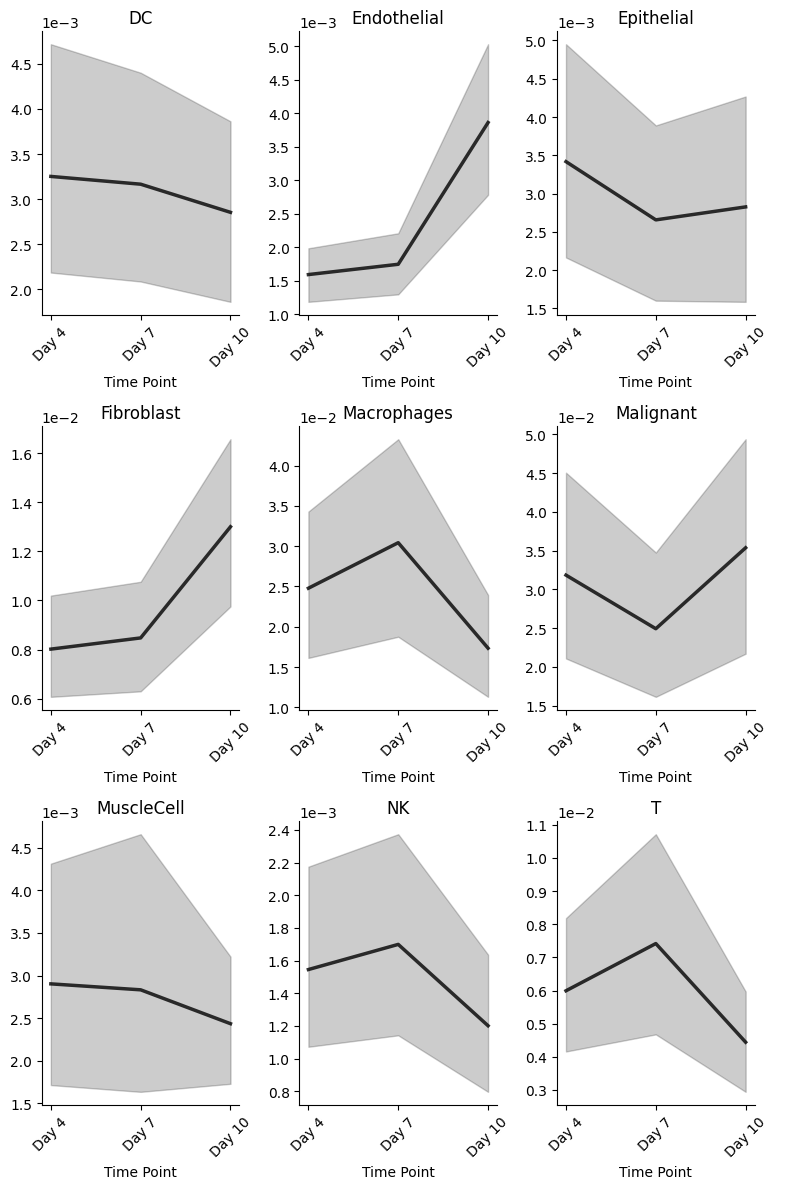

In [42]:
df_guides = cdfs.copy()
df_guides.marker = df_guides.marker.str.split('-').str[0]
df_guides = df_guides.groupby(['marker', 'celltype', 'cluster_cellcharter_givenk']).sum().reset_index()
df_guides.marker = df_guides.marker.astype(str).map(lambda x: 'Day 4' if x == '1' else ('Day 7' if x == '2' else 'Day 10'))

# 对同一时间的总bin数进行标准化
df_guides['count'] = df_guides.groupby('marker')['count'].transform(lambda x: x / x.sum())

guides_of_interest = df_guides.celltype.unique()

# 计算每个guide的marker顺序
order_dict = {}
celltypes_of_interest = df_guides.celltype.unique()
for celltype in celltypes_of_interest:
    celltype_data = df_guides[df_guides.celltype == celltype]
    mean_by_marker = celltype_data.groupby('marker')['count'].sum()
    order_dict[celltype] = ['Day 4', 'Day 7', 'Day 10']

# 创建颜色映射
guide_color_map = sns.color_palette("Set3", len(guides_of_interest))
marker_color_map = sns.color_palette("RdBu_r", len(df_guides['cluster_cellcharter_givenk'].unique()))
guide_color_map_dict = {celltype: guide_color_map[i] for i, celltype in enumerate(celltypes_of_interest)}
marker_color_map_dict = {marker: marker_color_map[i] for i, marker in enumerate(df_guides['cluster_cellcharter_givenk'].unique())}

# 创建子图
fig, axes = plt.subplots(3, 3, figsize=(8, 12))
plt.subplots_adjust(wspace=0, hspace=0.1)  # 手动设置ax之间的间隔
axes = axes.flatten()

# 设置统一的y轴范围
y_min = df_guides['count'].min()
y_max = df_guides['count'].max()

# 为每个guide绘制子图
for ax, celltype in zip(axes, celltypes_of_interest):
    # 获取该guide的数据并按order_dict排序
    celltype_data = df_guides[df_guides.celltype == celltype].copy()
    celltype_data['marker'] = pd.Categorical(celltype_data['marker'], 
                                         categories=order_dict[celltype],
                                         ordered=True)
    celltype_data = celltype_data.sort_values('marker')
    
    # 绘制线图
    sns.lineplot(data=celltype_data, x='marker', y='count', 
                ax=ax, color='black', linewidth=2.5, linestyle='-', alpha=0.8)
    
    # 设置标题和标签
    if ax != axes[8]: ax.legend([], frameon=False)
    else: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', fontsize='small', frameon=False)
    ax.set_title(celltype)
    ax.set_xlabel('Time Point')
    ax.set_ylabel('')
    ax.set_xticks(list(range(len(order_dict[celltype]))))
    ax.tick_params(axis='x', rotation=45)
    
    # 设置统一的y轴范围
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    # 移除右边和顶部的边框
    sns.despine(ax=ax)
plt.tight_layout()
plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/time_point_celltype_proportion.pdf", format="pdf", bbox_inches='tight')
plt.show()


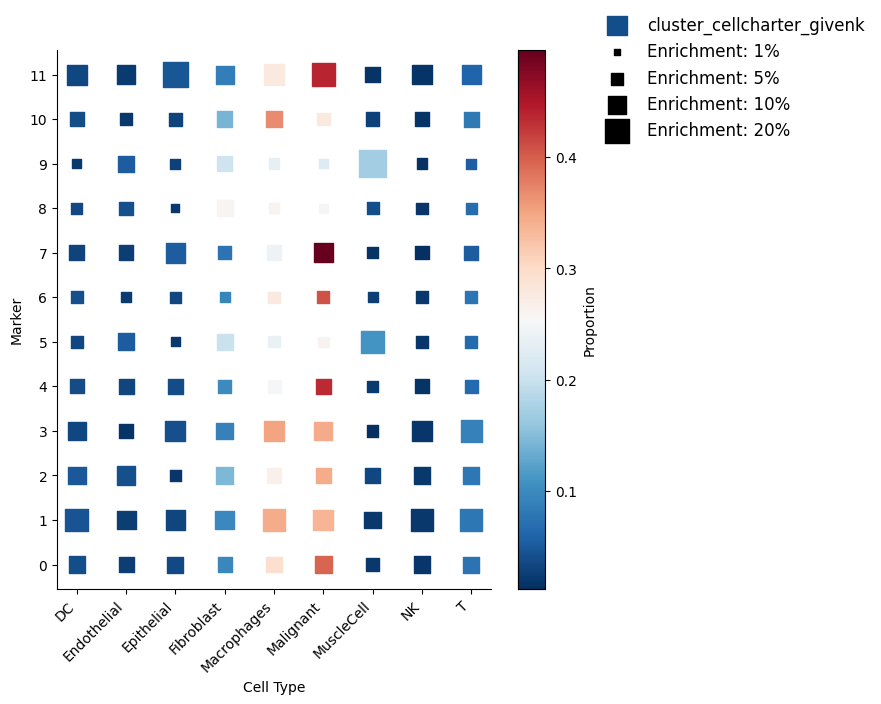

In [18]:
# cluster wise
pdf = cdfs.set_index(['cluster_cellcharter_givenk', 'celltype', 'marker']).unstack().sum(axis=1).unstack()
enrich_df = pdf.T.div(pdf.sum(axis=0), axis=0).melt(ignore_index=False).reset_index()
prop_df = pdf.T.div(pdf.sum(axis=1), axis=1).melt(ignore_index=False).reset_index()

plt.figure(figsize=(7, 7))
scatter = plt.scatter(data=enrich_df, x='celltype', y='cluster_cellcharter_givenk', s=enrich_df.value * 1500, marker='s', c=prop_df.value, cmap='RdBu_r', alpha=1)
plt.colorbar(label='Proportion')
plt.yticks(list(range(len(enrich_df['cluster_cellcharter_givenk'].unique()))), enrich_df['cluster_cellcharter_givenk'].unique())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Cell Type')
plt.ylabel('Marker')
plt.title('')

# 添加legend
legend_labels = [f'Enrichment: {size}' for size in ['1%', '5%', '10%', '20%']]  # 示例标签
sizes = [15, 75, 150, 300]  # 示例大小
for size, label in zip(sizes, legend_labels):
    plt.scatter([], [], s=size, label=label, color='black', alpha=1, marker='s')  # 添加空的scatter以创建legend
# plt.legend(title="Enrichment Size", loc='upper right', bbox_to_anchor=(1.8, 1), frameon=False)
scatter.get_figure().legend(title="", loc='upper right', bbox_to_anchor=(1.3, 0.95), frameon=False, fontsize='large')
sns.despine(left=False, bottom=False)

plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/cluster_celltype_enrichment.pdf", format="pdf", bbox_inches='tight')

plt.show()


In [ ]:
# Proportion of subtype T in all T ~ Fibro T


In [ ]:
# 

# NMF Program

In [113]:
import pickle
from bin import utils
model = pickle.load(open('./nmf_model.pkl', 'rb'))

# read in bins
adata = {}
for sample in ['B922-1', 'B922-2', 'B924-1', 'B924-2', 'B926-1', 'B926-2']:
    adata[sample] = sc.read_h5ad('./h5_files/' + sample + '.bin200.h5')
    adata[sample].obs['marker'] = sample
adata_combined = ad.concat(adata.values(), join='outer')
adata_combined.obs_names_make_unique()

fdata_bin200 = adata_combined[:, ~adata_combined.var_names.str.startswith('sg')].copy()
gdata_bin200 = adata_combined[:, adata_combined.var_names.str.startswith('sg')].copy()

gdata_bin200.X[:, gdata_bin200.var_names == 'sgNTC'] = gdata_bin200[:, 'sgNTC'].X.toarray() + gdata_bin200[:, 'sgnon-targeting_1_gene'].X.toarray() + gdata_bin200[:, 'sgnon-targeting_2_gene'].X.toarray()
gdata_bin200 = gdata_bin200[:, ~gdata_bin200.var_names.str.startswith('sgnon-targeting')].copy()

fdata_bin200 = utils.remove_mito_ribo_hk_lnc_genes(fdata_bin200)
fdata_bin200.layers['counts'] = fdata_bin200.X.copy()

sc.pp.normalize_total(fdata_bin200, inplace=True)
sc.pp.log1p(fdata_bin200)

sc.pp.highly_variable_genes(fdata_bin200, flavor='seurat', n_top_genes=2000)

gdata_bin200 = utils.combine_guide_replicates(gdata_bin200)

n_top=250
cnt_matrix = fdata_bin200.X.toarray()
cnt_matrix_trans = model.transform(cnt_matrix)
genes = fdata_bin200.var_names[np.argsort(model.components_, axis=1)[:, -n_top:].flatten()]

# cluster enrichment
fdata_bin100 = sc.read_h5ad('./RNA/Multitime.clustered.h5')
for i in range(4):
    sc.tl.score_genes(fdata_bin100, gene_list=genes[250 * i:250 * (i+1)].tolist(), score_name=f'Mask {i}')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/tmp/ipykernel_54603/47693854.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  fdata_bin200.layers['counts'] = fdata_bin200.X.copy()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The defa

violation: 1.0
violation: 0.24845045154453135
violation: 0.1572165527006977
violation: 0.11366506693786688
violation: 0.08417951517313313
violation: 0.06190055767245212
violation: 0.045401369191038224
violation: 0.0335316085942122
violation: 0.02436568525604771
violation: 0.017300958027420297
violation: 0.011931920153821789
violation: 0.007976292291648123
violation: 0.005153190635820225
violation: 0.003200090407396304
violation: 0.0019025760780084834
violation: 0.001159030477446007
violation: 0.0007322150707027957
violation: 0.00047123067824080754
violation: 0.0003357242382132685
violation: 0.00026056349488612254
violation: 0.000204065270606521
violation: 0.0001569558298895026
violation: 0.00011710550224687051
violation: 8.716838120112607e-05
Converged at iteration 25


In [ ]:
# dotplot

In [114]:
fdata_bin100

AnnData object with n_obs × n_vars = 118279 × 13177
    obs: 'marker', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter_givenk', 'Mask 0', 'Mask 1', 'Mask 2', 'Mask 3'
    var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
    uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_givenk_colors', 'log1p', 'rank_genes_groups', 'spatial_neighbors'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [73]:
import seaborn as sns

Text(0.5, 1.0, '1-1 Cluster Celltyping Porportion, normalized by bin')

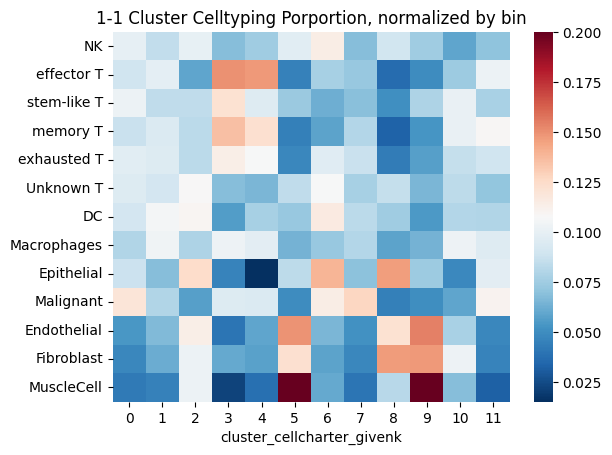

In [117]:
sns.heatmap(p_df.T.iloc[:-1], cmap="RdBu_r", vmax=0.2)
plt.title("1-1 Cluster Celltyping Porportion, normalized by bin")

/tmp/ipykernel_71854/3415189424.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = c_df.groupby("cluster_cellcharter_givenk").count()["Others"]
/tmp/ipykernel_71854/3415189424.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_df = c_df.groupby("cluster_cellcharter_givenk").sum()
/tmp/ipykernel_71854/3415189424.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = c_df.groupby("cluster_cellcha

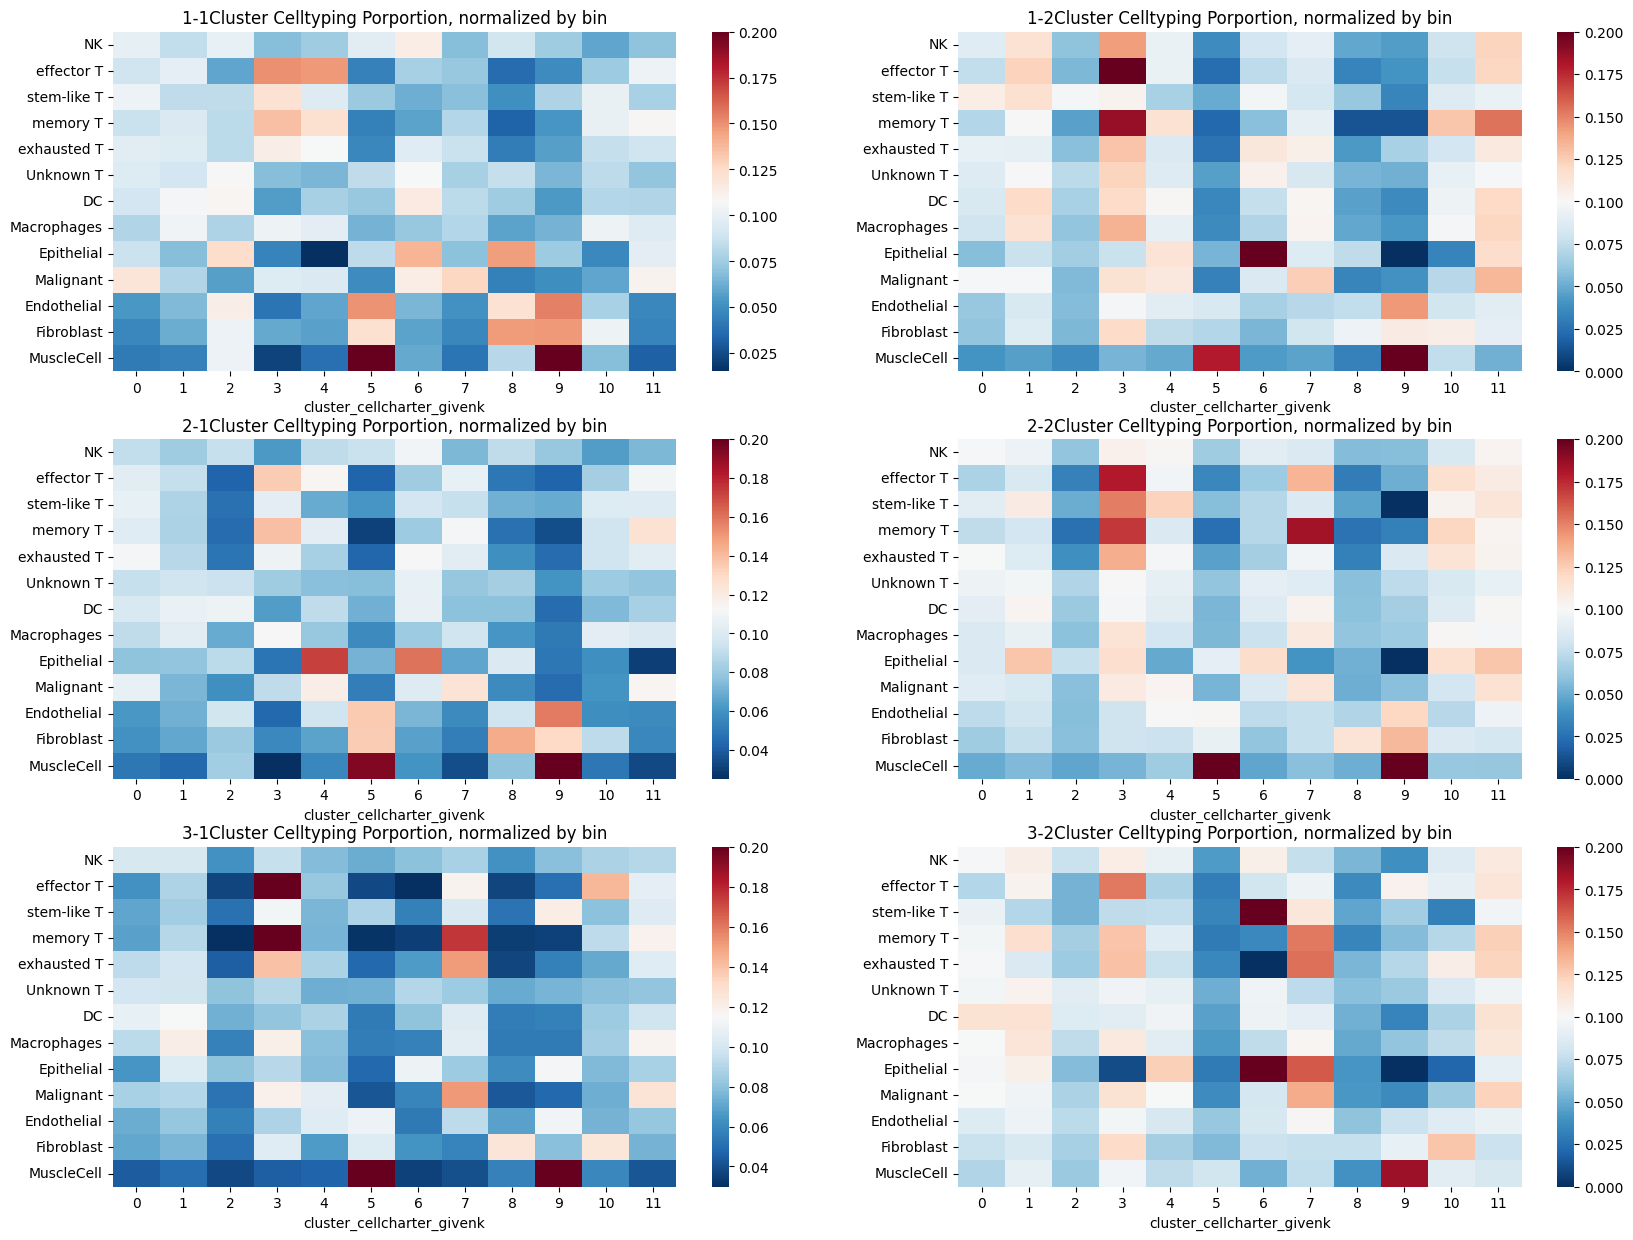

In [121]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
for idx, marker in enumerate(np.unique(fdata.obs["marker"])):
    fdata_ = fdata[fdata.obs["marker"] == marker].copy()
    cluster_data_ = cluster_data[cluster_data.obs["marker"] == marker].copy()
    c_df = fdata_.obs[["spatial_cov", "annotations"]].groupby(["spatial_cov"]).value_counts().unstack().reindex()
    c_df = pd.concat([c_df, cluster_data_.obs[["spatial_cov", "cluster_cellcharter_givenk"]].set_index("spatial_cov")], axis=1, join="inner")
    bin_counts = c_df.groupby("cluster_cellcharter_givenk").count()["Others"]

    p_df = c_df.groupby("cluster_cellcharter_givenk").sum()
    p_df = p_df.T / bin_counts
    p_df = p_df.T / p_df.sum(axis=1)
    sns.heatmap(p_df.T.iloc[:-1], cmap="RdBu_r", vmax=0.2, ax=ax[idx // 2, idx % 2])
    ax[idx // 2, idx % 2].set_title(marker + "Cluster Celltyping Porportion, normalized by bin")

# Mapping umap


In [4]:
import numpy as np

# 随机选择5%的细胞
n_cells = fdata.n_obs
n_sample = int(n_cells * 0.05)
random_indices = np.random.choice(n_cells, n_sample, replace=False)
fdata_sampled = fdata[random_indices, :].copy()


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


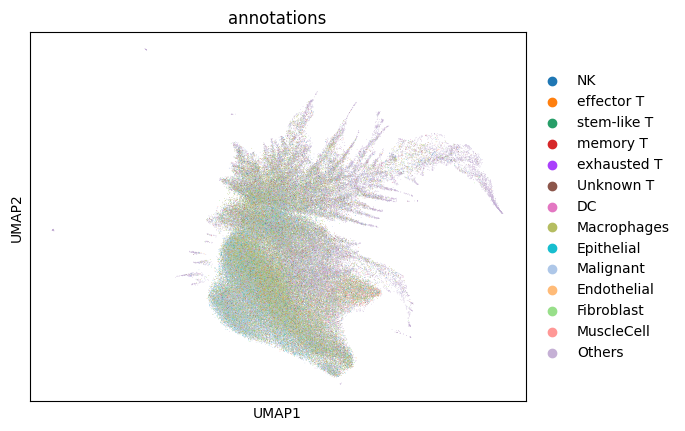

In [6]:
fdata_sampled.layers['counts'] = fdata_sampled.X.copy()
sc.pp.normalize_total(fdata_sampled, inplace=True)
sc.pp.log1p(fdata_sampled)
sc.tl.pca(fdata_sampled, svd_solver='arpack')
sc.pp.neighbors(fdata_sampled, n_neighbors=20, n_pcs=20)
sc.tl.umap(fdata_sampled)
sc.pl.umap(fdata_sampled, color='annotations')

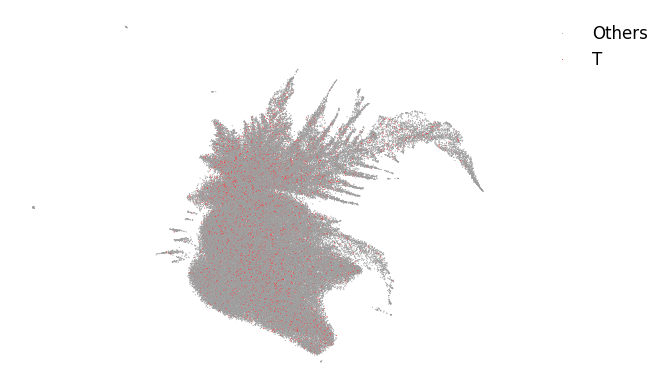

In [22]:
sns.scatterplot(x=fdata_sampled.obsm['X_umap'][:, 0], y=fdata_sampled.obsm['X_umap'][:, 1],
                hue=['T' if ann.endswith('T') else 'Others' for ann in fdata_sampled.obs['annotations']],
                s=0.5, palette=['gray', 'red'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', fontsize='large', frameon=False)
plt.xticks([])
plt.yticks([])
sns.despine(bottom=True, left=True)
plt.show()